In [68]:
# ==============================================================================
# Cell 1: Install and Import Dependencies
# ==============================================================================
# Uncomment if needed:
# !pip install opencv-python opencv-contrib-python numpy pillow matplotlib

import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import os
from pathlib import Path

%matplotlib inline

print("✅ Dependencies loaded successfully!")
# ==============================================================================

✅ Dependencies loaded successfully!


In [69]:
# ==============================================================================
# Cell 2: Enhanced Object Detector with 4-STAGE Duplicate Removal (INLIERS-BASED)
# ==============================================================================
class EnhancedObjectDetector:
    """
    Enhanced classical CV detector with 4-STAGE duplicate removal:
    - Multiple feature descriptors (ORB + SIFT)
    - Improved segmentation (overlap_thresh=0.6)
    - 4-stage duplicate removal (IoU + spatial + clustering + best-per-class)
    - Stage 4 uses INLIERS as best metric (better than confidence for feature matching)
    """
    
    def __init__(self, use_sift=True):
        self.orb = cv2.ORB_create(nfeatures=2000)
        self.use_sift = use_sift
        
        if use_sift:
            try:
                self.sift = cv2.SIFT_create(nfeatures=1000)
                print("✅ Using ORB + SIFT features")
            except:
                print("⚠️ SIFT not available, using only ORB")
                self.use_sift = False
        else:
            print("✅ Using ORB features only")
        
        self.matcher_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
        if self.use_sift:
            self.matcher_sift = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
        
        self.templates = {}
        print("EnhancedObjectDetector initialized")
    
    def preprocess_image(self, image):
        """Enhanced preprocessing with bilateral filter and CLAHE."""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        denoised = cv2.bilateralFilter(gray, 9, 75, 75)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(denoised)
        return enhanced
    
    def segment_objects_multi_method(self, image, min_area=1000):
        """Enhanced segmentation with 3 methods."""
        gray = self.preprocess_image(image)
        all_bboxes = []
        
        # Method 1: Canny edges
        edges = cv2.Canny(gray, 30, 100)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=3)
        dilated = cv2.dilate(closed, kernel, iterations=2)
        
        contours1, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours1:
            if cv2.contourArea(contour) > min_area:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = w / float(h) if h > 0 else 0
                if 0.1 < aspect_ratio < 10:
                    all_bboxes.append((x, y, w, h))
        
        # Method 2: Adaptive thresholding
        adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV, 11, 2)
        kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        morphed = cv2.morphologyEx(adaptive, cv2.MORPH_CLOSE, kernel2, iterations=2)
        
        contours2, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours2:
            if cv2.contourArea(contour) > min_area:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = w / float(h) if h > 0 else 0
                if 0.1 < aspect_ratio < 10:
                    all_bboxes.append((x, y, w, h))
        
        # Method 3: Otsu's thresholding
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        morphed2 = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
        
        contours3, _ = cv2.findContours(morphed2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours3:
            if cv2.contourArea(contour) > min_area:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = w / float(h) if h > 0 else 0
                if 0.1 < aspect_ratio < 10:
                    all_bboxes.append((x, y, w, h))
        
        bboxes = self._non_max_suppression(all_bboxes, overlap_thresh=0.6)
        
        print(f"📦 Found {len(bboxes)} object candidates (merged from {len(all_bboxes)} raw detections)")
        return bboxes
    
    def _non_max_suppression(self, boxes, overlap_thresh=0.5):
        """Apply NMS to merge overlapping boxes."""
        if len(boxes) == 0:
            return []
        
        boxes = np.array(boxes)
        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 0] + boxes[:, 2]
        y2 = boxes[:, 1] + boxes[:, 3]
        areas = boxes[:, 2] * boxes[:, 3]
        
        indices = np.argsort(areas)[::-1]
        keep = []
        
        while len(indices) > 0:
            i = indices[0]
            keep.append(i)
            
            if len(indices) == 1:
                break
            
            xx1 = np.maximum(x1[i], x1[indices[1:]])
            yy1 = np.maximum(y1[i], y1[indices[1:]])
            xx2 = np.minimum(x2[i], x2[indices[1:]])
            yy2 = np.minimum(y2[i], y2[indices[1:]])
            
            w = np.maximum(0, xx2 - xx1)
            h = np.maximum(0, yy2 - yy1)
            
            intersection = w * h
            union = areas[i] + areas[indices[1:]] - intersection
            iou = intersection / union
            
            indices = indices[1:][iou <= overlap_thresh]
        
        return boxes[keep].tolist()
    
    def normalize_template_size(self, image, target_size=256):
        """Resize template while preserving aspect ratio."""
        h, w = image.shape[:2]
        if max(h, w) > target_size:
            scale = target_size / max(h, w)
            new_w = int(w * scale)
            new_h = int(h * scale)
            return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
        return image
    
    def extract_features(self, gray_image):
        """Extract ORB and SIFT features."""
        features = {}
        
        kp_orb, desc_orb = self.orb.detectAndCompute(gray_image, None)
        features['orb'] = {'keypoints': kp_orb, 'descriptors': desc_orb}
        
        if self.use_sift:
            kp_sift, desc_sift = self.sift.detectAndCompute(gray_image, None)
            features['sift'] = {'keypoints': kp_sift, 'descriptors': desc_sift}
        
        return features
    
    def match_with_ransac(self, desc_template, desc_roi, kp_template, kp_roi, 
                         feature_type='orb', min_matches=10):
        """Match features with RANSAC verification."""
        if desc_template is None or desc_roi is None:
            return 0, 0.0
        
        if len(kp_template) < min_matches or len(kp_roi) < min_matches:
            return 0, 0.0
        
        matcher = self.matcher_orb if feature_type == 'orb' else self.matcher_sift
        
        try:
            matches = matcher.knnMatch(desc_template, desc_roi, k=2)
        except:
            return 0, 0.0
        
        ratio_thresh = 0.75 if feature_type == 'orb' else 0.7
        good_matches = []
        for match_pair in matches:
            if len(match_pair) == 2:
                m, n = match_pair
                if m.distance < ratio_thresh * n.distance:
                    good_matches.append(m)
        
        if len(good_matches) < min_matches:
            return 0, 0.0
        
        src_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_roi[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        if len(good_matches) >= 4:
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            inliers = mask.sum() if mask is not None else 0
            confidence = inliers / len(good_matches) if len(good_matches) > 0 else 0
            return int(inliers), float(confidence)
        
        return 0, 0.0
    
    def match_template_ensemble(self, roi_gray, template_data, min_matches=10):
        """Match using ensemble of ORB and SIFT (weighted 0.4/0.6)."""
        roi_features = self.extract_features(roi_gray)
        
        orb_inliers, orb_conf = self.match_with_ransac(
            template_data['features']['orb']['descriptors'],
            roi_features['orb']['descriptors'],
            template_data['features']['orb']['keypoints'],
            roi_features['orb']['keypoints'],
            'orb',
            min_matches
        )
        
        if self.use_sift and 'sift' in template_data['features']:
            sift_inliers, sift_conf = self.match_with_ransac(
                template_data['features']['sift']['descriptors'],
                roi_features['sift']['descriptors'],
                template_data['features']['sift']['keypoints'],
                roi_features['sift']['keypoints'],
                'sift',
                min_matches
            )
            
            total_inliers = orb_inliers + sift_inliers
            ensemble_conf = (0.4 * orb_conf + 0.6 * sift_conf)
            
            return total_inliers, ensemble_conf
        
        return orb_inliers, orb_conf
    
    def add_template(self, template_path, object_name):
        """Add template with ORB and SIFT features."""
        template_img = cv2.imread(template_path)
        if template_img is None:
            print(f"❌ Warning: Could not load template {template_path}")
            return
        
        template_img = self.normalize_template_size(template_img)
        gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
        features = self.extract_features(gray)
        
        template_data = {
            'image': template_img,
            'gray': gray,
            'features': features,
            'shape': gray.shape,
            'path': template_path
        }
        
        if object_name not in self.templates:
            self.templates[object_name] = []
        
        self.templates[object_name].append(template_data)
        
        orb_kp = len(features['orb']['keypoints'])
        sift_kp = len(features['sift']['keypoints']) if self.use_sift else 0
        print(f"✅ Added '{object_name}': ORB={orb_kp} kp" + 
              (f", SIFT={sift_kp} kp" if self.use_sift else ""))
    
    def load_templates_from_folder(self, templates_folder="templates"):
        """Load all templates from folder structure."""
        template_path = Path(templates_folder)
        if not template_path.exists():
            print(f"❌ Templates folder not found: {templates_folder}")
            return
        
        print(f"\n🔍 Loading templates from: {templates_folder}")
        print("="*60)
        
        for file in template_path.glob("*_template.*"):
            if file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                object_name = file.stem.replace('_template', '')
                self.add_template(str(file), object_name)
        
        for subfolder in template_path.iterdir():
            if subfolder.is_dir() and not subfolder.name.startswith('.'):
                object_name = subfolder.name
                for img_file in subfolder.glob("*.*"):
                    if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        self.add_template(str(img_file), object_name)
        
        print("="*60)
        print(f"📊 Loaded templates for {len(self.templates)} object types:")
        for obj_name, templates_list in self.templates.items():
            print(f"   • {obj_name}: {len(templates_list)} template(s)")
        print()
    
    def match_object_class(self, roi_gray, object_name, min_matches=8):
        """Match ROI against all templates for an object class."""
        if object_name not in self.templates:
            return 0, 0.0, -1
        
        best_inliers = 0
        best_confidence = 0.0
        best_template_idx = -1
        
        for idx, template_data in enumerate(self.templates[object_name]):
            inliers, confidence = self.match_template_ensemble(roi_gray, template_data, min_matches)
            
            if confidence > best_confidence:
                best_confidence = confidence
                best_inliers = inliers
                best_template_idx = idx
        
        return best_inliers, best_confidence, best_template_idx
    
    def _remove_duplicate_detections(self, detections, iou_threshold=0.7):
        """STAGE 1: IoU-based NMS."""
        if len(detections['boxes']) == 0:
            return detections
        
        label_groups = defaultdict(list)
        for i, label in enumerate(detections['labels']):
            label_groups[label].append(i)
        
        keep_indices = []
        
        for label, indices in label_groups.items():
            if len(indices) == 1:
                keep_indices.extend(indices)
                continue
            
            group_boxes = detections['boxes'][indices]
            group_scores = detections['scores'][indices]
            
            x1 = group_boxes[:, 0]
            y1 = group_boxes[:, 1]
            x2 = group_boxes[:, 2]
            y2 = group_boxes[:, 3]
            areas = (x2 - x1) * (y2 - y1)
            
            order = group_scores.argsort()[::-1]
            keep_local = []
            
            while len(order) > 0:
                i = order[0]
                keep_local.append(i)
                
                if len(order) == 1:
                    break
                
                xx1 = np.maximum(x1[i], x1[order[1:]])
                yy1 = np.maximum(y1[i], y1[order[1:]])
                xx2 = np.minimum(x2[i], x2[order[1:]])
                yy2 = np.minimum(y2[i], y2[order[1:]])
                
                w = np.maximum(0, xx2 - xx1)
                h = np.maximum(0, yy2 - yy1)
                
                intersection = w * h
                union = areas[i] + areas[order[1:]] - intersection
                iou = intersection / union
                
                order = order[1:][iou <= iou_threshold]
            
            keep_indices.extend([indices[k] for k in keep_local])
        
        filtered_detections = {
            'boxes': detections['boxes'][keep_indices] if len(keep_indices) > 0 else np.array([]),
            'scores': detections['scores'][keep_indices] if len(keep_indices) > 0 else np.array([]),
            'labels': [detections['labels'][i] for i in keep_indices],
            'inliers': [detections['inliers'][i] for i in keep_indices] if 'inliers' in detections else [],
            'template_used': [detections['template_used'][i] for i in keep_indices] if 'template_used' in detections else []
        }
        
        return filtered_detections
    
    def _remove_spatial_duplicates(self, detections, distance_threshold=200):
        """STAGE 2: Distance-based duplicate removal."""
        if len(detections['boxes']) == 0:
            return detections
        
        boxes = detections['boxes']
        scores = detections['scores']
        labels = detections['labels']
        
        centers = np.column_stack([
            (boxes[:, 0] + boxes[:, 2]) / 2,
            (boxes[:, 1] + boxes[:, 3]) / 2
        ])
        
        keep = []
        used = set()
        
        sorted_indices = np.argsort(scores)[::-1]
        
        for idx in sorted_indices:
            if idx in used:
                continue
            
            keep.append(idx)
            current_center = centers[idx]
            current_label = labels[idx]
            
            for other_idx in sorted_indices:
                if other_idx == idx or other_idx in used:
                    continue
                
                if labels[other_idx] != current_label:
                    continue
                
                distance = np.linalg.norm(centers[other_idx] - current_center)
                
                if distance < distance_threshold:
                    used.add(other_idx)
                    print(f"   🗑️  Removed duplicate {current_label} (distance={distance:.1f}px)")
        
        filtered = {
            'boxes': boxes[keep],
            'scores': scores[keep],
            'labels': [labels[i] for i in keep],
            'inliers': [detections['inliers'][i] for i in keep] if 'inliers' in detections else [],
            'template_used': [detections['template_used'][i] for i in keep] if 'template_used' in detections else []
        }
        
        return filtered
    
    def _cluster_nearby_detections(self, detections, cluster_distance=250):
        """STAGE 3: Cluster nearby detections and keep only the best."""
        if len(detections['boxes']) == 0:
            return detections
        
        boxes = detections['boxes']
        scores = detections['scores']
        labels = detections['labels']
        
        class_groups = defaultdict(list)
        for i, label in enumerate(labels):
            class_groups[label].append(i)
        
        keep_indices = []
        
        for class_name, indices in class_groups.items():
            if len(indices) == 1:
                keep_indices.extend(indices)
                continue
            
            class_boxes = boxes[indices]
            class_scores = scores[indices]
            centers = np.column_stack([
                (class_boxes[:, 0] + class_boxes[:, 2]) / 2,
                (class_boxes[:, 1] + class_boxes[:, 3]) / 2
            ])
            
            used = set()
            clusters = []
            
            for i in range(len(indices)):
                if i in used:
                    continue
                
                cluster = [i]
                used.add(i)
                
                for j in range(i + 1, len(indices)):
                    if j in used:
                        continue
                    
                    for k in cluster:
                        distance = np.linalg.norm(centers[j] - centers[k])
                        if distance < cluster_distance:
                            cluster.append(j)
                            used.add(j)
                            break
                
                clusters.append(cluster)
            
            for cluster in clusters:
                cluster_scores = [class_scores[i] for i in cluster]
                best_idx = cluster[np.argmax(cluster_scores)]
                keep_indices.append(indices[best_idx])
                
                if len(cluster) > 1:
                    print(f"   🔗 Clustered {len(cluster)} {class_name} detections → kept best (conf={class_scores[best_idx]:.3f})")
        
        filtered = {
            'boxes': boxes[keep_indices],
            'scores': scores[keep_indices],
            'labels': [labels[i] for i in keep_indices],
            'inliers': [detections['inliers'][i] for i in keep_indices] if 'inliers' in detections else [],
            'template_used': [detections['template_used'][i] for i in keep_indices] if 'template_used' in detections else []
        }
        
        return filtered
    
    def _keep_best_per_class(self, detections, metric='inliers'):
        """
        STAGE 4: Keep only the SINGLE BEST detection per class.
        
        FIX: Now uses INLIERS as the best metric (better than confidence).
        Inliers represent the number of geometrically consistent feature matches.
        
        Args:
            detections: Detection dictionary
            metric: 'inliers' (recommended) or 'confidence'
        
        Returns:
            Filtered detections with only 1 detection per class
        """
        if len(detections['boxes']) == 0:
            return detections
        
        boxes = detections['boxes']
        scores = detections['scores']
        labels = detections['labels']
        inliers = detections.get('inliers', [0] * len(labels))  # Fallback to 0 if not tracked
        
        # Group by class
        class_groups = defaultdict(list)
        for i, label in enumerate(labels):
            class_groups[label].append(i)
        
        keep_indices = []
        
        for class_name, indices in class_groups.items():
            if len(indices) == 1:
                # Only one detection for this class
                keep_indices.append(indices[0])
                print(f"   ✅ {class_name}: Only 1 detection, keeping it (inliers={inliers[indices[0]]}, conf={scores[indices[0]]:.3f})")
            else:
                # Multiple detections - keep the best one
                if metric == 'inliers' and inliers:
                    # Keep highest inliers (BEST for feature matching!)
                    class_inliers = [inliers[i] for i in indices]
                    best_idx = indices[np.argmax(class_inliers)]
                    keep_indices.append(best_idx)
                    print(f"   🏆 {class_name}: Kept BEST of {len(indices)} detections by INLIERS (inliers={inliers[best_idx]}, conf={scores[best_idx]:.3f}, discarded {len(indices)-1})")
                else:
                    # Fallback to confidence
                    best_idx = indices[np.argmax(scores[indices])]
                    keep_indices.append(best_idx)
                    print(f"   🏆 {class_name}: Kept BEST of {len(indices)} detections by CONFIDENCE (conf={scores[best_idx]:.3f}, discarded {len(indices)-1})")
        
        # Filter detections
        filtered = {
            'boxes': boxes[keep_indices],
            'scores': scores[keep_indices],
            'labels': [labels[i] for i in keep_indices],
            'inliers': [inliers[i] for i in keep_indices] if inliers else [],
            'template_used': [detections['template_used'][i] for i in keep_indices] if 'template_used' in detections else []
        }
        
        return filtered
    
    def detect_objects(self, image_path, object_list, min_confidence=0.35, 
                      apply_nms=True, iou_threshold=0.7, distance_threshold=300, 
                      cluster_distance=350, keep_best_only=True, best_metric='inliers'):
        """
        Detect objects with 4-STAGE duplicate removal.
        
        FIX: Now tracks INLIERS and uses them in Stage 4 (better than confidence).
        
        Args:
            image_path: Path to input image
            object_list: List of object names or "all"
            min_confidence: Minimum confidence threshold (default 0.35)
            apply_nms: Whether to apply duplicate removal (default True)
            iou_threshold: IoU threshold for Stage 1 (default 0.7)
            distance_threshold: Distance threshold for Stage 2 (default 300px)
            cluster_distance: Clustering distance for Stage 3 (default 350px)
            keep_best_only: Stage 4 - Keep only best per class (default True)
            best_metric: 'inliers' (recommended) or 'confidence' for Stage 4
        
        Returns:
            annotated_image: PIL Image with bounding boxes
            detections: Dictionary with boxes, scores, labels, inliers, template_used
        """
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if isinstance(object_list, str) and object_list.lower() == "all":
            object_list = list(self.templates.keys())
        
        active_objects = [obj for obj in object_list if obj in self.templates]
        
        if not active_objects:
            print("⚠️ Warning: No templates loaded for requested objects")
            return Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), {
                'boxes': np.array([]), 'scores': np.array([]), 'labels': [], 'inliers': []
            }
        
        print(f"🔍 Searching for: {active_objects}")
        print(f"📝 Total templates: {sum(len(self.templates[obj]) for obj in active_objects)}")
        
        bboxes = self.segment_objects_multi_method(image, min_area=800)
        
        # FIX: Now tracking inliers
        detections = {'boxes': [], 'scores': [], 'labels': [], 'inliers': [], 'template_used': []}
        
        for bbox_idx, bbox in enumerate(bboxes):
            x, y, w, h = bbox
            roi_gray = gray[y:y+h, x:x+w]
            
            if w < 30 or h < 30:
                continue
            
            best_match = None
            best_confidence = 0
            best_inliers = 0
            best_template_info = None
            
            for obj_name in active_objects:
                inliers, confidence, template_idx = self.match_object_class(
                    roi_gray, obj_name, min_matches=8
                )
                
                if confidence > best_confidence and confidence >= min_confidence:
                    best_confidence = confidence
                    best_match = obj_name
                    best_inliers = inliers  # FIX: Track inliers
                    best_template_info = f"{obj_name}_t{template_idx}"
            
            if best_match is not None:
                detections['boxes'].append([x, y, x+w, y+h])
                detections['scores'].append(best_confidence)
                detections['labels'].append(best_match)
                detections['inliers'].append(best_inliers)  # FIX: Store inliers
                detections['template_used'].append(best_template_info)
                print(f"  ✓ [{bbox_idx+1}] {best_match}: conf={best_confidence:.3f}, inliers={best_inliers}")
        
        detections['boxes'] = np.array(detections['boxes']) if detections['boxes'] else np.array([])
        detections['scores'] = np.array(detections['scores']) if detections['scores'] else np.array([])
        detections['inliers'] = np.array(detections['inliers']) if detections['inliers'] else np.array([])
        
        initial_count = len(detections['labels'])
        print(f"\n🎯 Initial detections: {initial_count} objects")
        
        # 4-STAGE duplicate removal
        if apply_nms and initial_count > 0:
            print(f"\n🔧 Stage 1: IoU-based NMS (threshold={iou_threshold})...")
            detections = self._remove_duplicate_detections(detections, iou_threshold=iou_threshold)
            after_iou = len(detections['labels'])
            print(f"   ✅ Removed {initial_count - after_iou} IoU-based duplicates")
            
            print(f"\n🔧 Stage 2: Spatial distance-based removal (threshold={distance_threshold}px)...")
            detections = self._remove_spatial_duplicates(detections, distance_threshold=distance_threshold)
            after_spatial = len(detections['labels'])
            print(f"   ✅ Removed {after_iou - after_spatial} spatial duplicates")
            
            print(f"\n🔧 Stage 3: Clustering nearby detections (cluster_distance={cluster_distance}px)...")
            detections = self._cluster_nearby_detections(detections, cluster_distance=cluster_distance)
            after_cluster = len(detections['labels'])
            print(f"   ✅ Removed {after_spatial - after_cluster} clustered duplicates")
            
            # FIX: Stage 4 now uses INLIERS
            if keep_best_only:
                print(f"\n🔧 Stage 4: Keeping only BEST detection per class (metric={best_metric})...")
                detections = self._keep_best_per_class(detections, metric=best_metric)
                final_count = len(detections['labels'])
                print(f"   ✅ Removed {after_cluster - final_count} additional detections (kept best only)")
            else:
                final_count = after_cluster
            
            print(f"\n✅ Final detections: {final_count} unique objects (removed {initial_count - final_count} total duplicates)")
        
        annotated_image = self._draw_boxes(image, detections)
        return annotated_image, detections
    
    def _draw_boxes(self, image, detections):
        """Draw bounding boxes with labels."""
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(image_rgb)
        draw = ImageDraw.Draw(pil_image)
        
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
        except:
            font = ImageFont.load_default()
        
        colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]
        
        for idx, (box, score, label) in enumerate(zip(detections['boxes'], detections['scores'], detections['labels'])):
            color = colors[idx % len(colors)]
            x1, y1, x2, y2 = box
            draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
            
            label_text = f"{label}: {score:.2f}"
            bbox = draw.textbbox((x1, y1), label_text, font=font)
            draw.rectangle([x1, y1 - (bbox[3]-bbox[1]) - 4, x1 + (bbox[2]-bbox[0]) + 4, y1], fill=color)
            draw.text((x1 + 2, y1 - (bbox[3]-bbox[1]) - 2), label_text, fill="white", font=font)
        
        return pil_image
    
    def visualize_results(self, original_path, annotated_image):
        """Display side-by-side comparison."""
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        original = cv2.imread(original_path)
        axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
        axes[0].axis('off')
        axes[1].imshow(annotated_image)
        axes[1].set_title("Enhanced Detection (4-Stage: Best by Inliers)", fontsize=14, fontweight='bold')
        axes[1].axis('off')
        plt.tight_layout()
        plt.show()

print("✅ EnhancedObjectDetector with 4-STAGE duplicate removal loaded!")
print("   Stage 4: Uses INLIERS (better than confidence for feature matching)!")

✅ EnhancedObjectDetector with 4-STAGE duplicate removal loaded!
   Stage 4: Uses INLIERS (better than confidence for feature matching)!


In [70]:
# ==============================================================================
# Cell 3: Initialize Detector and Load Templates
# ==============================================================================
detector = EnhancedObjectDetector(use_sift=True)
detector.load_templates_from_folder("templates")

✅ Using ORB + SIFT features
EnhancedObjectDetector initialized

🔍 Loading templates from: templates
✅ Added 'scissors': ORB=145 kp, SIFT=51 kp
✅ Added 'wrench': ORB=207 kp, SIFT=65 kp
✅ Added 'bottle': ORB=127 kp, SIFT=63 kp
✅ Added 'mug': ORB=302 kp, SIFT=61 kp
✅ Added 'screwdriver': ORB=85 kp, SIFT=42 kp
✅ Added 'mug': ORB=255 kp, SIFT=66 kp
✅ Added 'mug': ORB=232 kp, SIFT=64 kp
✅ Added 'mug': ORB=322 kp, SIFT=59 kp
✅ Added 'mug': ORB=268 kp, SIFT=45 kp
✅ Added 'shoes': ORB=186 kp, SIFT=94 kp
✅ Added 'shoes': ORB=218 kp, SIFT=58 kp
✅ Added 'shoes': ORB=217 kp, SIFT=66 kp
✅ Added 'shoes': ORB=177 kp, SIFT=65 kp
✅ Added 'shoes': ORB=209 kp, SIFT=66 kp
✅ Added 'shoes': ORB=190 kp, SIFT=59 kp
✅ Added 'screwdriver': ORB=136 kp, SIFT=43 kp
✅ Added 'screwdriver': ORB=125 kp, SIFT=36 kp
✅ Added 'screwdriver': ORB=210 kp, SIFT=38 kp
✅ Added 'screwdriver': ORB=85 kp, SIFT=42 kp
✅ Added 'scissors': ORB=165 kp, SIFT=41 kp
✅ Added 'scissors': ORB=158 kp, SIFT=42 kp
✅ Added 'scissors': ORB=85 kp, 

In [153]:
# ==============================================================================
# Cell 4: Run Detection with INLIERS-BASED Best Selection
# ==============================================================================
image_path = "data/examples/input_4.jpg"
objects_to_detect = "all"

# 4-STAGE REMOVAL with INLIERS-based best selection
annotated_img, detections = detector.detect_objects(
    image_path,
    objects_to_detect,
    min_confidence=0.35,
    apply_nms=True,
    iou_threshold=0.7,
    distance_threshold=0,
    cluster_distance=0,
    keep_best_only=True,
    best_metric='confidence'  # ← NEW: Use inliers instead of confidence
)

annotated_img.save("output_best_inliers.jpg")
print("\n💾 Saved to 'output_input_image_4.jpg'")

🔍 Searching for: ['scissors', 'wrench', 'bottle', 'mug', 'screwdriver', 'shoes', 'box']
📝 Total templates: 37
📦 Found 112 object candidates (merged from 121 raw detections)
  ✓ [1] wrench: conf=0.600, inliers=19
  ✓ [2] wrench: conf=0.622, inliers=18
  ✓ [3] shoes: conf=0.491, inliers=9
  ✓ [4] box: conf=0.600, inliers=31
  ✓ [7] wrench: conf=0.597, inliers=10
  ✓ [8] shoes: conf=0.550, inliers=11
  ✓ [9] bottle: conf=0.480, inliers=8
  ✓ [11] box: conf=0.544, inliers=29
  ✓ [12] shoes: conf=0.467, inliers=7
  ✓ [16] shoes: conf=0.525, inliers=7
  ✓ [22] box: conf=0.500, inliers=10
  ✓ [27] bottle: conf=0.533, inliers=8
  ✓ [31] shoes: conf=0.600, inliers=8

🎯 Initial detections: 13 objects

🔧 Stage 1: IoU-based NMS (threshold=0.7)...
   ✅ Removed 0 IoU-based duplicates

🔧 Stage 2: Spatial distance-based removal (threshold=0px)...
   ✅ Removed 0 spatial duplicates

🔧 Stage 3: Clustering nearby detections (cluster_distance=0px)...
   ✅ Removed 0 clustered duplicates

🔧 Stage 4: Keeping 

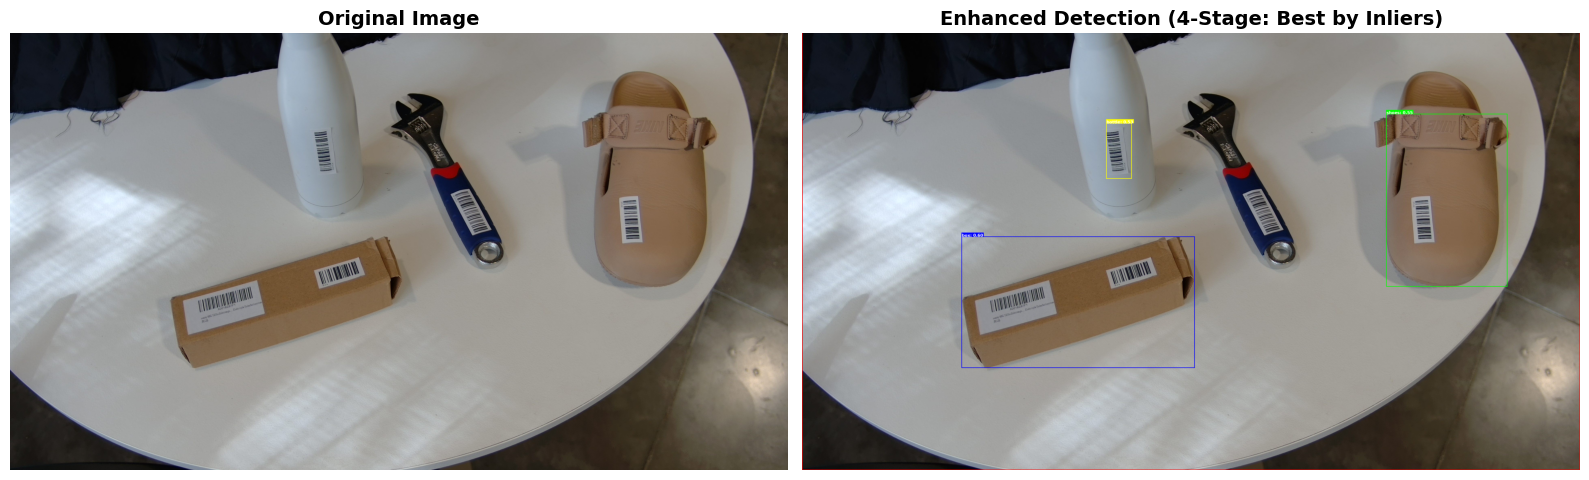

In [152]:
# ==============================================================================
# Cell 5: Visualize Results
# ==============================================================================
detector.visualize_results(image_path, annotated_img)

In [7]:
#)")
        print(f"   Template: {template_info}")
    
    print("\n" + "="*70)
    print("✅ Detection complete with triple-stage duplicate removal!")
else:
    print("\n⚠️ No detections found.")
    print("\n💡 Troubleshooting:")
    print("  • Try lowering min_confidence to 0.25-0.30")
    print("  • Check if templates match objects in the image")
    print("  • Verify templates loaded correctly (check Cell 3 output)")

print("="*70)


📊 DETECTION RESULTS (DUPLICATES REMOVED)

🎯 Total unique objects detected: 8

📦 Objects by class:
   • wrench: 1
   • box: 3
   • bottle: 2
   • shoes: 2

📋 Detailed detections:
----------------------------------------------------------------------

1. WRENCH
   Confidence: 0.950 (95.0%)
   Box: [0, 0, 3840, 2160]
   Size: 3840x2160 pixels
   Template: wrench_t8

2. BOX
   Confidence: 0.768 (76.8%)
   Box: [286, 979, 1375, 1422]
   Size: 1089x443 pixels
   Template: box_t0

3. BOTTLE
   Confidence: 0.600 (60.0%)
   Box: [1121, 541, 1241, 769]
   Size: 120x228 pixels
   Template: bottle_t2

4. BOX
   Confidence: 0.600 (60.0%)
   Box: [2170, 854, 3170, 1946]
   Size: 1000x1092 pixels
   Template: box_t0

5. SHOES
   Confidence: 0.600 (60.0%)
   Box: [2180, 1306, 2422, 1641]
   Size: 242x335 pixels
   Template: shoes_t3

6. BOTTLE
   Confidence: 0.600 (60.0%)
   Box: [124, 0, 1314, 355]
   Size: 1190x355 pixels
   Template: bottle_t2

7. BOX
   Confidence: 0.600 (60.0%)
   Box: [886, 111